DimensionPatch

In [3]:
import os   # for path operations
import datetime

import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18287920353768915856
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3168377241
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16024526574593437673
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
# nb_input_series : time + 9 IMU data + optional prev. beta (min 10)
# nb_outputs : beta () or quvaternion representation) (min 1)

def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
  model = Sequential()
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(nb_outputs,activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

In [6]:
def make_timeseries_instances(timeseries,window_size):
  timeseries = np.asarray(timeseries)
  assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
  X = np.atleast_3d(np.array([timeseries[start:start+window_size] for start in range(0,timeseries.shape[0]-window_size)]))
  y = timeseries[window_size:]
  return X,y

In [32]:
def evalute_timeseries(X, Y, window_size, filter_length, nb_filter, valid_split, test_split, patience, epochs, batch_size):
  early_stopping=EarlyStopping(patience=patience, verbose=1)
  checkpointer=ModelCheckpoint(filepath="weights_bazs.hdf5", save_best_only=True, verbose =1)

  nb_samples = X.shape[0]
  nb_series = X.shape[2]
  
  # Model definition (previously definied) 10 input chanel, 1 output chanel
  model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series,
                        nb_outputs=1,nb_filter=nb_filter)
  model.summary()
    
  valid_size = int(nb_samples*(1-test_split-valid_split))
  test_size = int(nb_samples*(1-test_split))
  X_train, Y_train = X[:valid_size], Y[:valid_size]
  X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
  X_test, Y_test   = X[test_size:], Y[test_size:]
    
  model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, Y_valid), verbose=2, callbacks = [checkpointer,early_stopping])
    
  preds=model.predict(X_test)
  targets = Y_test

  plt.plot(preds)
  plt.plot(targets)
  return preds, targets

# Load Data

In [8]:
lock_meas = '..\\DATA\\RAW\\Measure_02'
file_list = os.listdir(lock_meas)
nb_meas = len(file_list)/4
print("Number of Measurements: %0.f" % nb_meas)

Number of Measurements: 6


In [9]:
meas_list = []
for FILE_NAME in file_list:
    meas_list.append(FILE_NAME[0:22])
meas_list = list(set(meas_list))

In [34]:
# Load in one favourite measurement block
meas_id = 4
print(str(meas_list[meas_id]))

if meas_id>(nb_meas-1):
    print('Error: Out of range. Meas_id set to default 0')
    meas = 0
meas_date = str(meas_list[meas_id])

imu_data = pd.read_csv(lock_meas + '\\' + meas_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

mocap_data = pd.read_csv(lock_meas + '\\' + meas_date + 'MoCap.txt',
                                 sep='\t',
                                 decimal=',',
                                 names=['time', 'x', 'y', 'z', 'tracked', 'beta', 'Qx', 'Qy', 'Qz', 'Qw'])


2018_ 10_ 19_18_21_28_


In [35]:
#imu_data.head(5)

In [36]:
#mocap_data.head(5)

In [37]:
data = pd.merge(imu_data, mocap_data, on=['time'], how='inner')
len(data)

3123

In [38]:
data.head(2)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,x,y,z,tracked,beta,Qx,Qy,Qz,Qw
0,182127.6188,-0.001,-0.050,1.025,-0.765,0.222,-0.148,-0.373,-0.251,0.052,0.725,0.212,-0.735,1.0,19.857,0.013,-0.172,0.003,0.985
1,182127.6277,-0.001,-0.049,1.025,-1.108,0.181,-0.215,-0.376,-0.251,0.052,0.725,0.212,-0.735,1.0,19.845,0.013,-0.172,0.003,0.985


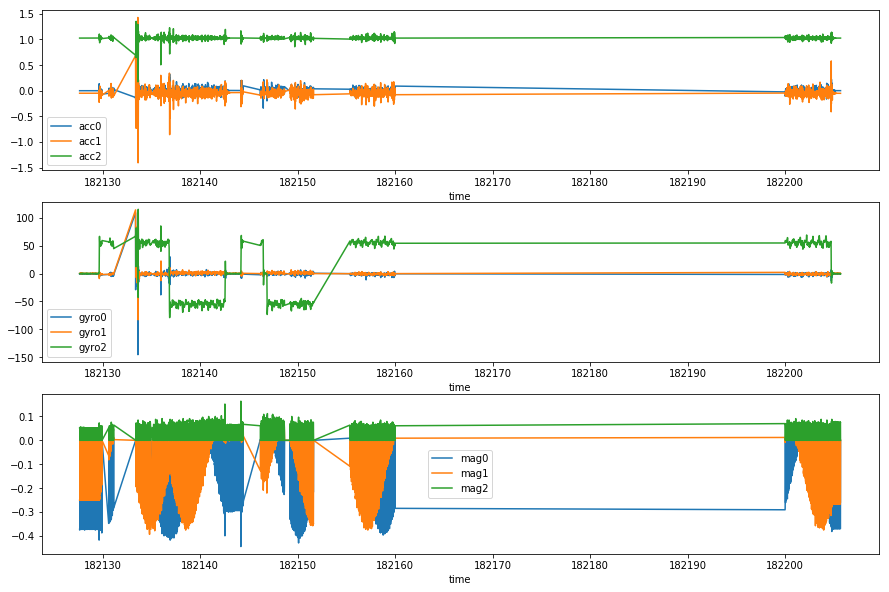

In [39]:
f1, (ax1, ax2, ax3) = plt.subplots(3, 1)
data.plot(x='time', y='acc0', figsize=(15,10), ax=ax1)
data.plot(x='time', y='acc1', ax=ax1)
data.plot(x='time', y='acc2', ax=ax1)
data.plot(x='time', y='gyro0', ax=ax2)
data.plot(x='time', y='gyro1', ax=ax2)
data.plot(x='time', y='gyro2', ax=ax2)
data.plot(x='time', y='mag0', ax=ax3)
data.plot(x='time', y='mag1', ax=ax3)
data.plot(x='time', y='mag2', ax=ax3)

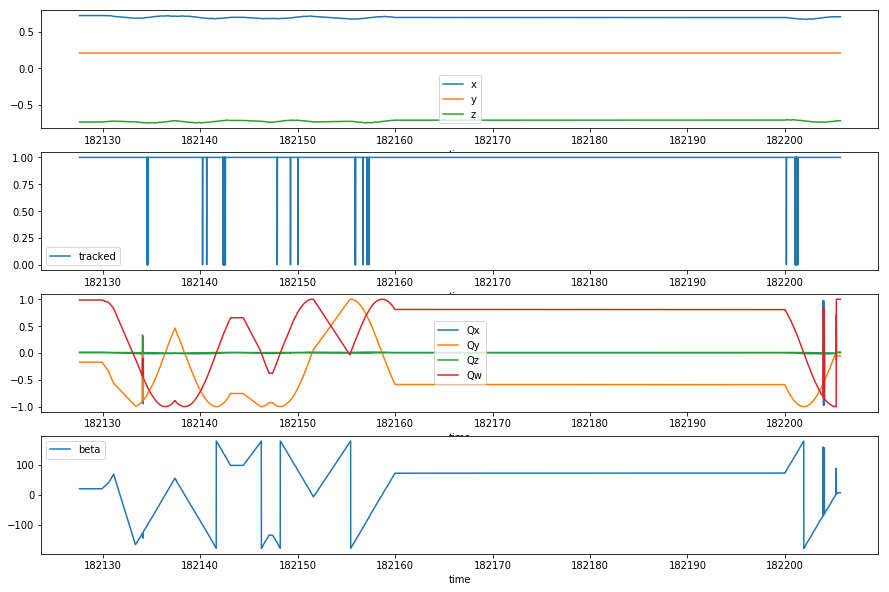

In [40]:
f2, (ax4, ax5, ax6, ax7) = plt.subplots(4, 1)
data.plot(x='time', y='x', figsize=(15,10), ax=ax4)
data.plot(x='time', y='y', ax=ax4)
data.plot(x='time', y='z', ax=ax4)
data.plot(x='time', y='tracked', ax=ax5)
data.plot(x='time', y='Qx', ax=ax6)
data.plot(x='time', y='Qy', ax=ax6)
data.plot(x='time', y='Qz', ax=ax6)
data.plot(x='time', y='Qw', ax=ax6)
data.plot(x='time', y='beta', ax=ax7)

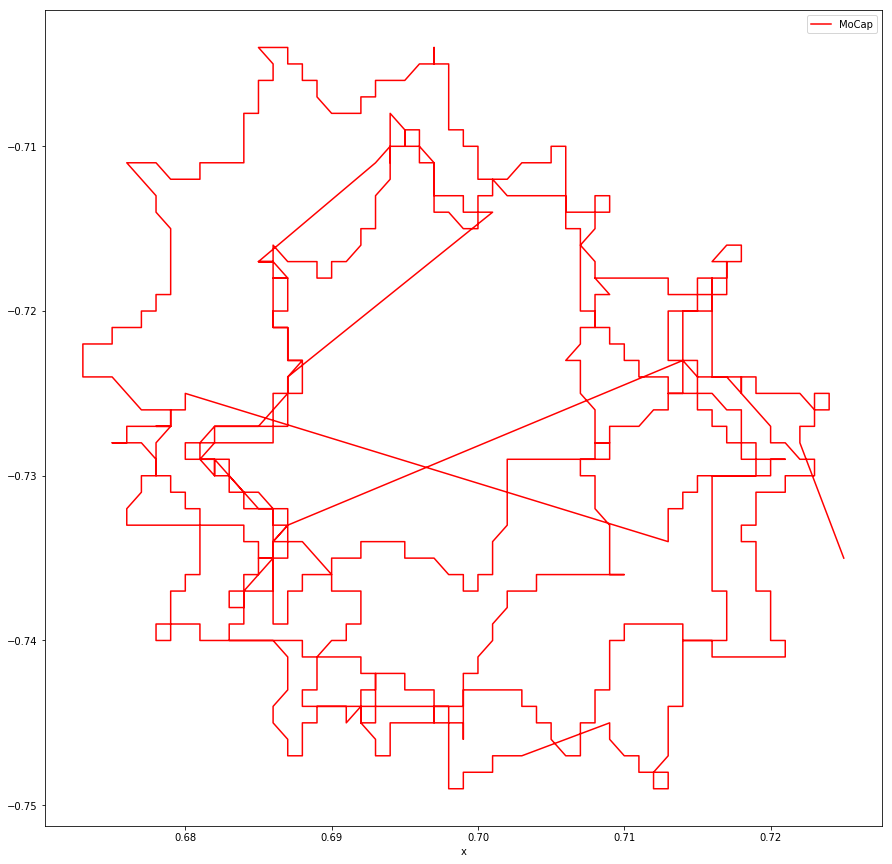

In [41]:
data.plot(x='x', y='z', color='red', figsize=(15,15), label='MoCap')

In [42]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 100
patience=50
batch_size = 16
vs = 0.15
ts = 0.15

In [43]:
data.head(1)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,x,y,z,tracked,beta,Qx,Qy,Qz,Qw
0,182127.6188,-0.001,-0.05,1.025,-0.765,0.222,-0.148,-0.373,-0.251,0.052,0.725,0.212,-0.735,1.0,19.857,0.013,-0.172,0.003,0.985


In [44]:
Y = np.array(data['x'][window_size:])
X= np.array(data[list(data.columns[0:9])])

In [45]:
X = np.atleast_3d(np.array([X[start:start+window_size] for start in range(0,X.shape[0]-window_size)]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 16, 4)             184       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________
Train on 217

 - 1s - loss: 0.4438 - mean_absolute_error: 0.6660 - val_loss: 0.4404 - val_mean_absolute_error: 0.6636

Epoch 00035: val_loss improved from 0.44082 to 0.44044, saving model to weights_bazs.hdf5
Epoch 36/100
 - 1s - loss: 0.4434 - mean_absolute_error: 0.6657 - val_loss: 0.4400 - val_mean_absolute_error: 0.6633

Epoch 00036: val_loss improved from 0.44044 to 0.44004, saving model to weights_bazs.hdf5
Epoch 37/100
 - 1s - loss: 0.4430 - mean_absolute_error: 0.6654 - val_loss: 0.4396 - val_mean_absolute_error: 0.6630

Epoch 00037: val_loss improved from 0.44004 to 0.43960, saving model to weights_bazs.hdf5
Epoch 38/100
 - 1s - loss: 0.4426 - mean_absolute_error: 0.6651 - val_loss: 0.4391 - val_mean_absolute_error: 0.6626

Epoch 00038: val_loss improved from 0.43960 to 0.43913, saving model to weights_bazs.hdf5
Epoch 39/100
 - 1s - loss: 0.4421 - mean_absolute_error: 0.6647 - val_loss: 0.4386 - val_mean_absolute_error: 0.6622

Epoch 00039: val_loss improved from 0.43913 to 0.43864, saving 


Epoch 00074: val_loss improved from 0.37474 to 0.37015, saving model to weights_bazs.hdf5
Epoch 75/100
 - 1s - loss: 0.3707 - mean_absolute_error: 0.6087 - val_loss: 0.3653 - val_mean_absolute_error: 0.6043

Epoch 00075: val_loss improved from 0.37015 to 0.36531, saving model to weights_bazs.hdf5
Epoch 76/100
 - 1s - loss: 0.3657 - mean_absolute_error: 0.6045 - val_loss: 0.3602 - val_mean_absolute_error: 0.6001

Epoch 00076: val_loss improved from 0.36531 to 0.36020, saving model to weights_bazs.hdf5
Epoch 77/100
 - 1s - loss: 0.3604 - mean_absolute_error: 0.6002 - val_loss: 0.3548 - val_mean_absolute_error: 0.5956

Epoch 00077: val_loss improved from 0.36020 to 0.35480, saving model to weights_bazs.hdf5
Epoch 78/100
 - 1s - loss: 0.3549 - mean_absolute_error: 0.5955 - val_loss: 0.3491 - val_mean_absolute_error: 0.5908

Epoch 00078: val_loss improved from 0.35480 to 0.34912, saving model to weights_bazs.hdf5
Epoch 79/100
 - 1s - loss: 0.3490 - mean_absolute_error: 0.5906 - val_loss: 0

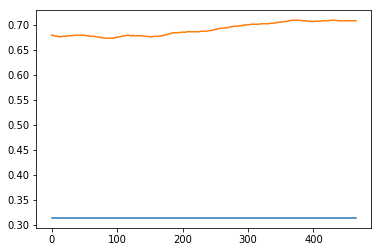

In [46]:
pred, target = evalute_timeseries(X, Y, window_size,filter_length,nb_filter, vs, ts, patience, epochs, batch_size)

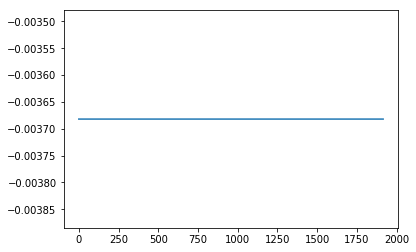

In [31]:
plt.plot(pred)